### Conditional GAN on MNIST

This notebook demonstrates how to implement a conditional GAN on MNIST. The model is based on the paper [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784).

### CGAN Generator and Discriminator

We can use the generator and discriminator implementations from the DCGAN example with the addition of the conditioning by y. The generator takes both a random noise vector z and a class label y as input and generates an image. The discriminator takes both an image and a class label and predicts if the image is real or fake. Both the generator and discriminator are conditioned on y.

In [15]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Generator(nn.Module):
    def __init__(self, latent_dim, num_classes=10):
        super(Generator, self).__init__()
        kernel_size = 5
        self.blocks = nn.ModuleList()
        self.fc = nn.Linear(latent_dim + num_classes, 7 * 7 * 128)
        self.block1 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 128, kernel_size, stride=2, padding=2, output_padding=1),
        )
        self.block2 = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size, stride=2, padding=2, output_padding=1),
        )
        self.block3 = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size, stride=1, padding=2),
        )
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(32, 1, kernel_size, stride=1, padding=2),
            nn.Sigmoid()
        )
    def forward(self, z, y):
        x = torch.cat([z, y], dim=1)
        x = self.fc(x)
        x = x.view(-1, 128, 7, 7)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        img = self.block4(x)
        return img



In [16]:
class Discriminator(nn.Module):
    def __init__(self, num_classes=10):
        super(Discriminator, self).__init__()
        kernel_size = 5
        layer_filters = [32, 64, 128, 256]
        self.block1 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(2, layer_filters[0], kernel_size, stride=2, padding=2),
        )
        self.block2 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(layer_filters[0], layer_filters[1], kernel_size, stride=2, padding=2),
        )
        self.block3 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(layer_filters[1], layer_filters[2], kernel_size, stride=2, padding=2),
        )
        self.block4 = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.Conv2d(layer_filters[2], layer_filters[3], kernel_size, stride=1, padding=2),     
        )
        self.fc1 = nn.Linear(num_classes, 28 * 28)
        self.fc2 = nn.Linear(4 * 4 * layer_filters[3], 1)
        

    def forward(self, x, y):
        y = self.fc1(y)
        y = y.view(-1, 1, 28, 28)
        x = torch.cat([x, y], dim=1)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = torch.flatten(x, 1)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

### Adversarial Network

The adversarial network is similar to the one described in our DCGAN example, except it takes a class label y as input. 

In [17]:
class Adversarial(nn.Module):
    def __init__(self, generator, discriminator):
        super(Adversarial, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, z, y):
        img = self.generator(z, y)
        validity = self.discriminator(img, y)
        return validity

### Train Data Loader

This is the same as the data loader from the DCGAN example, except that we will use the class label y. 

In [18]:
# Define the transformation to apply to the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='~/data', train=True, transform=transform, download=True)
#test_dataset = torchvision.datasets.MNIST(root='~/data', train=False, transform=transform, download=True)

# Create dataloaders for training and testing
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### Plotting Generated Images

We will also reuse the `save_generated_images` function from the DCGAN example to plot our generated images. The only difference is the conditioning label y which ranges from 0 to 9 and then repeats again from 0 to 5 to assign 16 conditioning labels for the 16 generated images.

In [19]:
import torchvision.utils as vutils

def save_generated_images(generator, device, epoch=1, num_classes=10):
    # Generate random noise vectors
    noise = torch.randn(16, 100).to(device)
    
    labels = torch.cat([torch.eye(num_classes),torch.eye(num_classes)[0:6]], dim=0).to(device)
    
    # Generate images using the generator
    with torch.no_grad():
        generated_images = generator(noise, labels).detach().cpu()
    
    # Create a grid of 4 x 4 images
    grid = vutils.make_grid(generated_images, nrow=4, padding=2, normalize=True)
    
    # Save the grid of images
    filename = 'cgan_ep-%s.png' % (epoch)
    vutils.save_image(grid, filename)

### CGAN Training

This is the same as the training loop from the DCGAN example, except that we will also pass the conditioning label y to the generator and discriminator.

In [20]:
import torch
def train(generator, discriminator, 
          adversarial, trainloader,
          epochs=50, num_classes=10):
    generator.train()
    discriminator.train()
    criterion = nn.BCELoss()
    lr = 2e-4
    decay = 6e-8
    factor = 0.5
    optimizer_g = torch.optim.RMSprop(generator.parameters(), 
                                    lr=lr*factor, weight_decay=decay*factor)    
    optimizer_d = torch.optim.RMSprop(discriminator.parameters(),
                                    lr=lr, weight_decay=decay) 
    
    for epoch in range(epochs):
        for i, (real_imgs, labels) in enumerate(trainloader):
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)
            batch_size = real_imgs.shape[0]
            real_labels = torch.ones(batch_size, 1, requires_grad=False).to(device)
            fake_labels = torch.zeros(batch_size, 1, requires_grad=False).to(device)
            z = torch.randn(batch_size, 100).to(device)
            
            # Train discriminator
            optimizer_d.zero_grad()
            generator.eval()

            real_labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
            
            labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            fake_labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

            with torch.no_grad():
                fake_imgs = generator(z, fake_labels_one_hot)
        
            real_out = discriminator(real_imgs, real_labels_one_hot)
            fake_out = discriminator(fake_imgs, fake_labels_one_hot)
            loss_real = criterion(real_out, real_labels)
            loss_fake = criterion(fake_out, fake_labels)
            loss_d = loss_real + loss_fake
            loss_d.backward()
            optimizer_d.step()
            
            # Train generator
            optimizer_g.zero_grad()
            generator.train()
            z = torch.randn(batch_size, 100, requires_grad=False).to(device)
            labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            fake_labels_one_hot = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()
            
            fake_out = adversarial(z, fake_labels_one_hot)
            loss_g = criterion(fake_out, real_labels)
            loss_g.backward()
            optimizer_g.step()
            if i % 100 == 0:
                print('Epoch: %d, Iter: %d, Loss D: %.6f, Loss G: %.6f' % (epoch, i, loss_d.item(), loss_g.item()))

        print('Learning Rate (Generator):', optimizer_g.param_groups[0]['lr'])
        print('Learning Rate (Discriminator):', optimizer_d.param_groups[0]['lr'])
        save_generated_images(generator, device, epoch=epoch)


### Training the CGAN

This is the same as the training loop from the DCGAN example.

In [21]:
generator = Generator(100).to(device)
discriminator = Discriminator().to(device)
adversarial = Adversarial(generator, discriminator).to(device)
epochs = 50
train(generator, discriminator, adversarial, train_dataloader, epochs=epochs)


Epoch: 0, Iter: 0, Loss D: 1.385651, Loss G: 0.760963
Epoch: 0, Iter: 100, Loss D: 0.000233, Loss G: 8.638338
Epoch: 0, Iter: 200, Loss D: 0.000061, Loss G: 9.948948
Epoch: 0, Iter: 300, Loss D: 0.000200, Loss G: 10.308721
Epoch: 0, Iter: 400, Loss D: 0.087152, Loss G: 4.529482
Epoch: 0, Iter: 500, Loss D: 0.004172, Loss G: 6.993400
Epoch: 0, Iter: 600, Loss D: 0.216465, Loss G: 2.298440
Epoch: 0, Iter: 700, Loss D: 0.907734, Loss G: 1.122909
Epoch: 0, Iter: 800, Loss D: 0.977368, Loss G: 1.332402
Epoch: 0, Iter: 900, Loss D: 1.103352, Loss G: 1.380704
Learning Rate (Generator): 0.0001
Learning Rate (Discriminator): 0.0002
Epoch: 1, Iter: 0, Loss D: 1.081104, Loss G: 0.867039
Epoch: 1, Iter: 100, Loss D: 0.925242, Loss G: 0.834287
Epoch: 1, Iter: 200, Loss D: 0.881908, Loss G: 2.161982
Epoch: 1, Iter: 300, Loss D: 0.825591, Loss G: 1.725976
Epoch: 1, Iter: 400, Loss D: 0.879976, Loss G: 2.405997
Epoch: 1, Iter: 500, Loss D: 0.883921, Loss G: 1.183729
Epoch: 1, Iter: 600, Loss D: 1.1605

## Generate an Animated GIF 

To see the evolution of the generated samples, we will generate an animated gif of all the images saved during training.

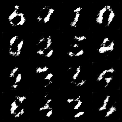

KeyboardInterrupt: 

In [23]:
import imageio
import time
from IPython.display import Image
from IPython.display import display
from IPython.display import clear_output

# List of PNG image filenames
image_filenames = [f"cgan_ep-{i}.png" for i in range(epochs)]

# Read the PNG images and append them to a list
images = []
for filename in image_filenames:
    image = imageio.imread(filename)
    images.append(image)

# Save the list of images as a GIF
output_filename = 'cgan_anim.gif'
imageio.mimsave(output_filename, images, duration=0.5)


# Display the GIF
while True:
    clear_output(wait=True)
    display(Image(filename=output_filename))
    time.sleep(2)
